In [1]:
from common import teams, colors, text, Fonts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.interpolate import interp1d

In [2]:
df = pd.read_csv("schedule.csv")
df

,date,home,score,away
0,2022-04-29,LA,2-1,NC
1,2022-04-30,POR,3-0,KC
2,2022-05-01,WAS,2-1,RGN
3,2022-05-01,HOU,0-1,SD
4,2022-05-01,ORL,0-3,NJNY
...,...,...,...,...
127,2022-10-01,NJNY,3-3,POR
128,2022-10-01,WAS,1-2,HOU
129,2022-10-01,LOU,1-0,KC
130,2022-10-01,RGN,3-0,ORL


In [3]:
df = df.sort_values("date")
df["score"] = df["score"].str.split("-").apply(lambda x: (int(x[0]), int(x[1])))
df

,date,home,score,away
0,2022-04-29,LA,"(2, 1)",NC
1,2022-04-30,POR,"(3, 0)",KC
5,2022-04-30,CHI,"(2, 1)",LOU
2,2022-05-01,WAS,"(2, 1)",RGN
3,2022-05-01,HOU,"(0, 1)",SD
...,...,...,...,...
130,2022-10-01,RGN,"(3, 0)",ORL
127,2022-10-01,NJNY,"(3, 3)",POR
128,2022-10-01,WAS,"(1, 2)",HOU
129,2022-10-01,LOU,"(1, 0)",KC


In [4]:
team_points = {}

for team in teams:
    points = []
    for i, game in df[(df["home"] == team) | (df["away"] == team)].iterrows():
        score = game["score"]
        if game["away"] == team:
            score = score[::-1]

        points.append(1 if score[0] == score[1] else (3 if score[0] > score[1] else 0))
    team_points[team] = pd.Series(points)

In [5]:
window_size = 5

df2 = pd.DataFrame(columns=range(0,22-window_size + 1))

for team, series in team_points.items():
    windows = series.rolling(window_size)
    moving_sum = windows.sum()
    moving_sum_list = moving_sum.tolist()

    # Remove null entries from the list
    final_list = moving_sum_list[window_size - 1:]
    df2.loc[team] = pd.Series(final_list)
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
NJNY,9.0,6.0,6.0,6.0,6.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
POR,6.0,6.0,6.0,8.0,11.0,11.0,9.0,11.0,11.0,9.0,11.0,10.0,7.0,7.0,7.0,7.0,10.0,11.0
LA,9.0,6.0,7.0,7.0,4.0,5.0,8.0,7.0,5.0,8.0,8.0,8.0,9.0,8.0,5.0,7.0,4.0,3.0
CHI,8.0,8.0,9.0,9.0,9.0,11.0,9.0,8.0,5.0,7.0,4.0,3.0,6.0,7.0,7.0,7.0,7.0,7.0
WAS,6.0,4.0,4.0,4.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,6.0,8.0,7.0,7.0,6.0
SD,12.0,9.0,7.0,5.0,6.0,6.0,9.0,8.0,8.0,10.0,7.0,4.0,7.0,9.0,6.0,9.0,10.0,8.0
NC,4.0,7.0,7.0,7.0,7.0,5.0,3.0,3.0,6.0,8.0,7.0,9.0,12.0,12.0,9.0,12.0,12.0,10.0
RGN,6.0,9.0,8.0,8.0,10.0,10.0,8.0,8.0,10.0,8.0,5.0,7.0,10.0,8.0,10.0,13.0,13.0,13.0
LOU,8.0,8.0,7.0,6.0,4.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,5.0,4.0,6.0,9.0
HOU,8.0,11.0,9.0,8.0,8.0,7.0,4.0,6.0,9.0,9.0,10.0,13.0,10.0,8.0,6.0,8.0,5.0,8.0


<Figure size 28800x16200 with 0 Axes>

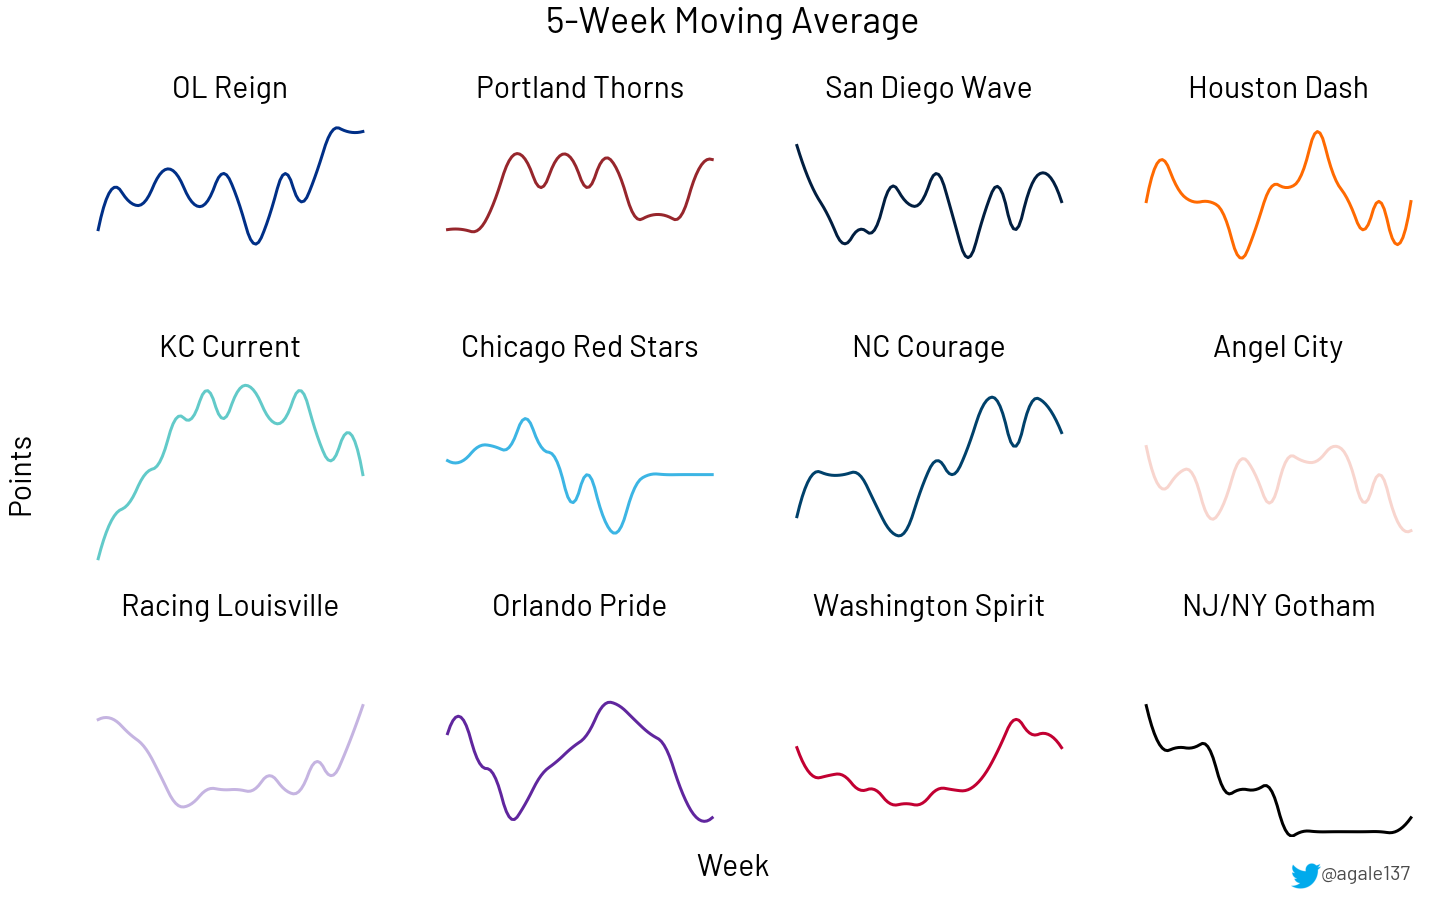

In [7]:
plt.rcParams["figure.figsize"] = (24, 13.5)
plt.figure(dpi=1200, facecolor="white")
fig, axs = plt.subplots(3, 4)
fig.patch.set_facecolor("white")

smooth = True

# Sort teams to order them by rank
standings = list(
    map(
        lambda t: t[0],
        sorted(
            {k: v.sum() for k, v in team_points.items()}.items(),
            key=lambda kv: kv[1],
            reverse=True,
        ),
    )
)

# Plot each team as a subplot
for i, team in enumerate(standings):
    ax = axs[int(i / 4), i % 4]

    if smooth:
        f = interp1d(list(df2.columns), df2.loc[team].to_numpy(), kind="quadratic")
        x2 = np.linspace(0, 22 - window_size, num=100)
        y2 = f(x2)
        ax.plot(
            x2,
            y2,
            linewidth=3,
            color=colors[team],
        )
    else:
        ax.plot(
            df2.columns,
            df2.loc[team],
            linewidth=3,
            color=colors[team],
        )
    ax.set_title(teams[team], fontproperties=Fonts.BARLOW, size=30)
    ax.axis("off")
    ax.set_ylim([-0.4, 3 * window_size])
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("5-Week Moving Average", fontproperties=Fonts.BARLOW, size=36)
fig.supxlabel("Week", y=0.08, fontproperties=Fonts.BARLOW, size=30)
fig.supylabel("Points", x=0.08, fontproperties=Fonts.BARLOW, size=30)

# Username and Twitter logo
axs[2, 3].text(
    17,
    -3,
    "@agale137",
    color="black",
    fontsize=20,
    alpha=0.7,
    fontproperties=Fonts.BARLOW,
    va="center",
    ha="right",
)
im = plt.imread("/home/agale/nwsl-analytics/src/common/twitter.png")
newax = fig.add_axes([0.81, 0.07, 0.03, 0.03], anchor="SE", zorder=1)
newax.imshow(im)
newax.axis("off")

# Save image
plt.savefig("moving_sum.png", bbox_inches="tight", pad_inches=0.5)